# Text Mining -  Group Project

---

# Preparing the Data

In [2]:
import gensim
import nltk
import timeit
import numpy as np
import pandas as pd
import random
import re
import string
import umap

from sklearn.utils import shuffle
from nltk.tokenize import regexp_tokenize
from sklearn.model_selection import train_test_split

In [3]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dasha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dasha\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\dasha\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## Loading the Data

### Reddit News

In [12]:
import os
os.getcwd()

'C:\\Users\\dasha'

In [4]:
reddit_path = "data/reddit_worldnews.csv"
reddit_file = pd.read_csv(reddit_path, encoding="utf-8", encoding_errors="ignore")
print("reddit_file_clmns:", reddit_file.columns)
reddit = pd.DataFrame(reddit_file["title"]).rename(columns={"title":"Headline"})
reddit.head()

reddit_file_clmns: Index(['time_created', 'date_created', 'up_votes', 'down_votes', 'title',
       'over_18', 'author', 'subreddit'],
      dtype='object')


,Headline
0,Scores killed in Pakistan clashes
1,Japan resumes refuelling mission
2,US presses Egypt on Gaza border
3,Jump-start economy: Give health care to all
4,Council of Europe bashes EU&UN terror blacklist


### Ireland News

In [7]:
ireland_path = "data/ireland-news-headlines.csv"
ireland_file = pd.read_csv(ireland_path, encoding="utf-8", encoding_errors="ignore")
print("ireland_file_clmns:", ireland_file.columns)
ireland_filtered_date = ireland_file[(ireland_file["publish_date"] >= 20080125) & 
                                     (ireland_file["publish_date"] <= 20161122)]
ireland = pd.DataFrame(ireland_filtered_date["headline_text"]).rename(columns={"headline_text":"Headline"})
ireland.head()

ireland_file_clmns: Index(['publish_date', 'headline_category', 'headline_text'], dtype='object')


,Headline
747865,Egypt moves to close Gaza border breach
747866,Almost two-thirds of voters undecided on EU tr...
747867,Jacob Fruitfield factory to lay off 220 staff
747868,Bono says rich world failing anti-poverty camp...
747869,Government; NRA announce €1.68bn roads plan


In [16]:
type(ireland_file)

pandas.core.frame.DataFrame

## Preprocessing

In [24]:
# Pre-processing 
# Regular expression used for tokenization
pattern = r'''(?x)    
(?:[A-Z]\.)+          
|\w+(?:-\w+)*         
|\$?\d+(?:\.\d+)?%?   
|\.\.\.               
|[][.,;"\'?():-_`]  
'''

# Lemmatizer used 
lemmatizer = nltk.WordNetLemmatizer()

def preprocessing(df):
    """Input: dataframe
       Output: preprocessed dataframe"""
    
    # Get the stopwords and punctuation
    stopwords = nltk.corpus.stopwords.words('english')
    punct = list(string.punctuation)
    
    # Initialize tokenized list of headlines
    # Get list of headlines
    headlns_lst = df["Headline"].to_list()
    
    tokenized_lines = []
    for headln in headlns_lst:
        line = str(headln).strip().lower()
        line = regexp_tokenize(line, pattern)
        line = [tok for tok in line if tok not in stopwords and tok not in punct and tok.isalpha() and len(tok)>2]
        tokenized_lines.append(line)
    
    # Initialize lemmatized list of headlines
    pp_df = pd.DataFrame(columns = ["Headline"])
    lemmatized_lines = [[lemmatizer.lemmatize(token) for token in headln] for headln in tokenized_lines]
    line_df = pd.DataFrame({"Headline": lemmatized_lines})
    pp_df = pp_df.append(line_df, ignore_index=True)

    return pp_df

### Reddit News

In [25]:
reddit_pp = preprocessing(reddit)
reddit_pp
t = timeit.timeit(lambda:reddit_pp)
print(t)
print(reddit_pp)

C:\Users\dasha\AppData\Local\Temp\ipykernel_27316\351899760.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pp_df = pp_df.append(line_df, ignore_index=True)


0.13380150002194569
                                                 Headline
0                        [score, killed, pakistan, clash]
1                    [japan, resume, refuelling, mission]
2                            [press, egypt, gaza, border]
3                           [economy, give, health, care]
4              [council, europe, bash, terror, blacklist]
...                                                   ...
509231  [heil, trump, donald, trump, white, nationalis...
509232    [people, speculating, could, madeleine, mccann]
509233     [professor, receives, arab, researcher, award]
509234  [nigel, farage, attack, response, trump, ambas...
509235  [palestinian, wielding, knife, shot, dead, wes...

[509236 rows x 1 columns]


### Ireland News

In [10]:
ireland_pp = preprocessing(ireland)
ireland_pp

C:\Users\dasha\AppData\Local\Temp\ipykernel_27316\2543675033.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pp_df = pp_df.append(line_df, ignore_index=True)


,Headline
0,"[egypt, move, close, gaza, border, breach]"
1,"[almost, voter, undecided, treaty]"
2,"[jacob, fruitfield, factory, lay, staff]"
3,"[bono, say, rich, world, failing, campaign]"
4,"[government, nra, announce, road, plan]"
...,...
598832,"[vincent, kompany, suffers, injury, eight, yea..."
598833,"[baby, needed, resuscitation, birth, inquiry, ..."
598834,"[spur, whimper, bright, light, monaco]"
598835,"[leicester, continue, contrasting, form, toppi..."


## Latent Dirichlet Analysis
Gensim Implementation

## Reddit

In [12]:
#Exploring vocabulary size
all_words = [word for tokens in reddit_pp['Headline'] for word in tokens]
headline_lengths = [len(tokens) for tokens in reddit_pp['Headline']]

vocab = sorted(list(set(all_words)))

print('{} words total, with a vocabulary size of {}'.format(len(all_words), len(vocab)))
print('Max headline length is {}'.format(max(headline_lengths)))

4816959 words total, with a vocabulary size of 73363
Max headline length is 38


In [54]:
#Dictionary representation. Each word in the headline corpus a unique integer identifier.
reddit_dict = gensim.corpora.Dictionary(reddit_pp.Headline)
#view integer mappings
reddit_dict.token2id

{'clash': 0,
 'killed': 1,
 'pakistan': 2,
 'score': 3,
 'japan': 4,
 'mission': 5,
 'refuelling': 6,
 'resume': 7,
 'border': 8,
 'egypt': 9,
 'gaza': 10,
 'press': 11,
 'care': 12,
 'economy': 13,
 'give': 14,
 'health': 15,
 'bash': 16,
 'blacklist': 17,
 'council': 18,
 'europe': 19,
 'terror': 20,
 'bale': 21,
 'behind': 22,
 'castle': 23,
 'farmer': 24,
 'hay': 25,
 'hide': 26,
 'illegal': 27,
 'presto': 28,
 'tried': 29,
 'unveils': 30,
 'gridlock': 31,
 'protest': 32,
 'strike': 33,
 'mismanagement': 34,
 'program': 35,
 'nicolas': 36,
 'ryanair': 37,
 'sarkozy': 38,
 'sue': 39,
 'threatens': 40,
 'met': 41,
 'missile': 42,
 'plan': 43,
 'polish': 44,
 'resistance': 45,
 'shield': 46,
 'town': 47,
 'video': 48,
 'archbishop': 49,
 'call': 50,
 'canterbury': 51,
 'cruel': 52,
 'law': 53,
 'new': 54,
 'online': 55,
 'punish': 56,
 'thoughtless': 57,
 'time': 58,
 'word': 59,
 'cleansing': 60,
 'envoy': 61,
 'ethnic': 62,
 'kenya': 63,
 'top': 64,
 'violence': 65,
 'building': 66,

In [55]:
#Filtering
reddit_dict.filter_extremes(no_below=10, no_above=0.5)
print('Filtered size of vocabulary:', len(reddit_dict))

#Manually filtering out the word 'say' and its variations
del_ids = [k for k,v in reddit_dict.items() if v=='say']
reddit_dict.filter_tokens(bad_ids=del_ids)

del_ids = [k for k,v in reddit_dict.items() if v=='said']
reddit_dict.filter_tokens(bad_ids=del_ids)

del_ids = [k for k,v in reddit_dict.items() if v=='saying']
reddit_dict.filter_tokens(bad_ids=del_ids)

print('Final filtered size of vocabulary:', len(reddit_dict))

Filtered size of vocabulary: 18676
Final filtered size of vocabulary: 18673


In [56]:
#Bag of Words - counts how many times a word token occurs within a headline
#Output contains a vector for each headline, in the form of (word id, frequency of word occurrence in a headline).

reddit_BOW = [reddit_dict.doc2bow(headline) for headline in reddit_pp['Headline']]

In [59]:
#LDA 
#For the final model, I’ve fit a model with 10 topics and 10 passes.

from gensim.models.ldamodel import LdaModel

k = 10
reddit_lda = LdaModel(reddit_BOW,
                      num_topics = k,
                      id2word = reddit_dict,
                      random_state = 1,
                      passes=10)

reddit_lda.show_topics()

[(0,
  '0.043*"russia" + 0.018*"china" + 0.018*"japan" + 0.017*"deal" + 0.017*"brexit" + 0.016*"russian" + 0.013*"vote" + 0.013*"president" + 0.012*"election" + 0.011*"germany"'),
 (1,
  '0.042*"attack" + 0.033*"killed" + 0.021*"kill" + 0.019*"pakistan" + 0.015*"air" + 0.013*"strike" + 0.012*"bomb" + 0.012*"least" + 0.012*"iraqi" + 0.012*"army"'),
 (2,
  '0.043*"isi" + 0.025*"iran" + 0.022*"mosul" + 0.019*"nuclear" + 0.014*"power" + 0.012*"state" + 0.011*"rio" + 0.011*"scientist" + 0.009*"may" + 0.009*"fight"'),
 (3,
  '0.050*"syria" + 0.032*"minister" + 0.029*"syrian" + 0.027*"turkey" + 0.021*"israel" + 0.019*"state" + 0.017*"indian" + 0.014*"israeli" + 0.013*"obama" + 0.013*"palestinian"'),
 (4,
  '0.021*"philippine" + 0.020*"sea" + 0.016*"court" + 0.015*"found" + 0.014*"duterte" + 0.012*"global" + 0.010*"chinese" + 0.010*"crisis" + 0.010*"year" + 0.009*"island"'),
 (5,
  '0.020*"death" + 0.017*"year" + 0.016*"turkish" + 0.012*"turkey" + 0.012*"child" + 0.011*"man" + 0.010*"arrested"

## PyLDAvis
A library is a great way to visualize topics from a topic model.

In [60]:
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim_models.prepare(reddit_lda, reddit_BOW, dictionary = reddit_lda.id2word)
vis

C:\Users\dasha\AppData\Local\Programs\Python\Python310\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.168912 -0.063656       1        1  11.342736
1      0.109764  0.328859       2        1  11.179797
5      0.122150  0.042175       3        1  10.710628
8      0.071851 -0.233916       4        1  10.254794
4      0.246949 -0.105637       5        1  10.062909
6      0.059577  0.151726       6        1   9.852810
7      0.134068 -0.118741       7        1   9.650905
3     -0.195722  0.140358       8        1   9.625993
9     -0.210164 -0.032222       9        1   8.675314
2     -0.169560 -0.108945      10        1   8.644113, topic_info=           Term          Freq         Total Category  logprob  loglift
3466      syria  22243.000000  22243.000000  Default  30.0000  30.0000
265       china  34553.000000  34553.000000  Default  29.0000  29.0000
225      russia  22539.000000  22539.000000  Default  28.0000  28.0000
461      attack  24253.000000  24253.000000  Default  27.0000  27.0000
10645       isi  17220.000000  17220.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
382      report   2469.364184  11935.758250  Topic10  -5.0920   0.8727
529    official   2466.277016  12115.376745  Topic10  -5.0932   0.8565
53          new   2615.571341  23200.786515  Topic10  -5.0345   0.2656
111      leader   2347.648186  12014.458903  Topic10  -5.1425   0.8156
282    military   2052.686864  12356.120221  Topic10  -5.2768   0.6533

[461 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
200        7  0.999428     access
3337       9  0.999615  according
1856       1  0.120827   activist
1856       2  0.085403   activist
1856       3  0.793613   activist
...      ...       ...        ...
841        4  0.999404    zealand
18603      4  0.000839       zika
18603      5  0.996467       zika
18603      7  0.000419       zika
18603      8  0.001678       zika

[575 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 6, 9, 5, 7, 8, 4, 10, 3])

## Word Cloud

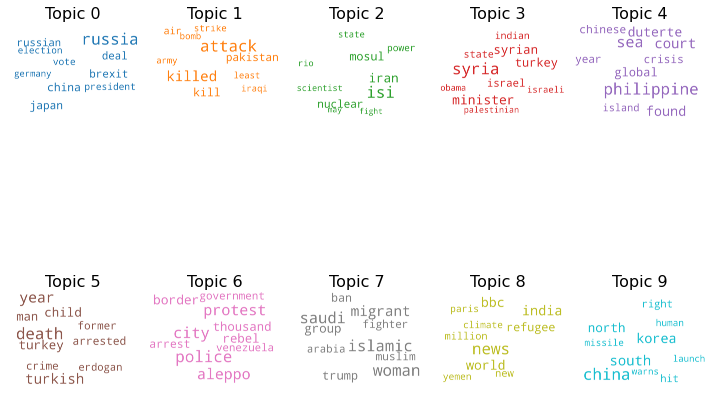

In [62]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = reddit_lda.show_topics(formatted=False)

fig, axes = plt.subplots(2, 5, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

---

## Ireland

In [63]:
#Exploring vocabulary size
all_words = [word for tokens in ireland_pp['Headline'] for word in tokens]
headline_lengths = [len(tokens) for tokens in ireland_pp['Headline']]

vocab = sorted(list(set(all_words)))

print('{} words total, with a vocabulary size of {}'.format(len(all_words), len(vocab)))
print('Max headline length is {}'.format(max(headline_lengths)))

3034305 words total, with a vocabulary size of 66374
Max headline length is 26


In [84]:
#Dictionary representation. Each word in the tweet corpus a unique integer identifier.
ireland_dict = gensim.corpora.Dictionary(ireland_pp.Headline)

#View integer mappings
ireland_dict.token2id

{'border': 0,
 'breach': 1,
 'close': 2,
 'egypt': 3,
 'gaza': 4,
 'move': 5,
 'almost': 6,
 'treaty': 7,
 'undecided': 8,
 'voter': 9,
 'factory': 10,
 'fruitfield': 11,
 'jacob': 12,
 'lay': 13,
 'staff': 14,
 'bono': 15,
 'campaign': 16,
 'failing': 17,
 'rich': 18,
 'say': 19,
 'world': 20,
 'announce': 21,
 'government': 22,
 'nra': 23,
 'plan': 24,
 'road': 25,
 'boy': 26,
 'collapsing': 27,
 'critical': 28,
 'school': 29,
 'hospital': 30,
 'room': 31,
 'single': 32,
 'criticised': 33,
 'decision': 34,
 'gun': 35,
 'psni': 36,
 'stun': 37,
 'cab': 38,
 'case': 39,
 'gilligan': 40,
 'testifies': 41,
 'considering': 42,
 'hse': 43,
 'ihca': 44,
 'offer': 45,
 'revised': 46,
 'commissioner': 47,
 'north': 48,
 'victim': 49,
 'conflict': 50,
 'fund': 51,
 'govt': 52,
 'resolution': 53,
 'study': 54,
 'agency': 55,
 'aid': 56,
 'irish': 57,
 'kenya': 58,
 'return': 59,
 'alert': 60,
 'boil': 61,
 'clare': 62,
 'coli': 63,
 'issued': 64,
 'notice': 65,
 'drug': 66,
 'gardaí': 67,
 'mak

In [88]:
#Filtering
ireland_dict.filter_extremes(no_below=10, no_above=0.5)
print('Filtered size of vocabulary:', len(ireland_dict))

#Manually filtering out the word 'say' and its variations
del_ids = [k for k,v in ireland_dict.items() if v=='say']
ireland_dict.filter_tokens(bad_ids=del_ids)

del_ids = [k for k,v in ireland_dict.items() if v=='said']
ireland_dict.filter_tokens(bad_ids=del_ids)

del_ids = [k for k,v in ireland_dict.items() if v=='saying']
ireland_dict.filter_tokens(bad_ids=del_ids)

del_ids = [k for k,v in ireland_dict.items() if v=='ireland']
ireland_dict.filter_tokens(bad_ids=del_ids)

del_ids = [k for k,v in ireland_dict.items() if v=='irish']
ireland_dict.filter_tokens(bad_ids=del_ids)

del_ids = [k for k,v in ireland_dict.items() if v=='dublin']
ireland_dict.filter_tokens(bad_ids=del_ids)

print('Final filtered size of vocabulary:', len(ireland_dict))

Filtered size of vocabulary: 17813
Final filtered size of vocabulary: 17810


In [89]:
#Bag of Words - counts how many times a word token occurs within a tweet
#Output contains a vector for each tweet, in the form of (word id, frequency of word occurrence in tweet).

ireland_BOW = [ireland_dict.doc2bow(headline) for headline in ireland_pp['Headline']]

In [90]:
#LDA
#For the final model, I’ve fit a model with 10 topics and 10 passes.

from gensim.models.ldamodel import LdaModel

k = 10
ireland_lda = LdaModel(ireland_BOW,
                      num_topics = k,
                      id2word = ireland_dict,
                      passes=10)

ireland_lda.show_topics()

[(0,
  '0.020*"court" + 0.017*"new" + 0.015*"people" + 0.014*"plan" + 0.013*"move" + 0.012*"case" + 0.012*"health" + 0.012*"rule" + 0.012*"action" + 0.011*"martin"'),
 (1,
  '0.027*"time" + 0.022*"make" + 0.014*"best" + 0.012*"sport" + 0.012*"garda" + 0.011*"john" + 0.010*"euro" + 0.009*"house" + 0.009*"inquiry" + 0.008*"point"'),
 (2,
  '0.051*"review" + 0.022*"set" + 0.015*"job" + 0.014*"work" + 0.012*"hospital" + 0.011*"new" + 0.011*"rio" + 0.010*"crisis" + 0.010*"home" + 0.010*"china"'),
 (3,
  '0.019*"week" + 0.019*"city" + 0.017*"election" + 0.015*"return" + 0.014*"michael" + 0.013*"game" + 0.012*"thing" + 0.011*"school" + 0.011*"help" + 0.011*"public"'),
 (4,
  '0.036*"brexit" + 0.019*"deal" + 0.019*"bank" + 0.015*"take" + 0.014*"profit" + 0.013*"strike" + 0.013*"european" + 0.012*"end" + 0.012*"five" + 0.012*"way"'),
 (5,
  '0.033*"trump" + 0.022*"day" + 0.020*"tax" + 0.020*"life" + 0.019*"need" + 0.016*"face" + 0.014*"cup" + 0.013*"kenny" + 0.013*"new" + 0.012*"child"'),
 (6,


---

## PyLDAvis
A library is a great way to visualize topics from a topic model.

In [91]:
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim_models.prepare(ireland_lda, ireland_BOW, dictionary = ireland_lda.id2word)
vis

C:\Users\dasha\AppData\Local\Programs\Python\Python310\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.139163  0.219858       1        1  10.716115
1     -0.331556 -0.008309       2        1  10.326812
8     -0.007547 -0.301134       3        1  10.251831
7     -0.106963 -0.219531       4        1  10.223765
0      0.116436  0.093369       5        1  10.218633
9      0.126339 -0.003538       6        1  10.151053
6      0.125992 -0.060882       7        1   9.906110
5      0.104192  0.045007       8        1   9.672761
3     -0.089857  0.181135       9        1   9.429570
2      0.202127  0.054025      10        1   9.103350, topic_info=         Term          Freq         Total Category  logprob  loglift
256    review  13145.000000  13145.000000  Default  30.0000  30.0000
17716  brexit  11154.000000  11154.000000  Default  29.0000  29.0000
319      year   9779.000000   9779.000000  Default  28.0000  28.0000
2948    trump   9084.000000   9084.000000  Default  27.0000  27.0000
244       man  11178.000000  11178.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
178       hit   2282.844264   3677.281531  Topic10  -4.7357   1.9198
955      home   2630.986003   7527.496603  Topic10  -4.5937   1.3453
164       new   2874.269753  18860.033536  Topic10  -4.5053   0.5153
379    market   1966.652615   4220.268686  Topic10  -4.8847   1.6330
367       cut   1881.757437   3840.032767  Topic10  -4.9289   1.6833

[377 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
4758      9  0.999545  abortion
2529      6  0.999268   accused
545       5  0.999655    action
815       7  0.999601     ahead
110       1  0.999612       air
...     ...       ...       ...
18        4  0.750667     world
18        7  0.249331     world
2056     10  0.999684     would
319       4  0.999904      year
630       9  0.999845     young

[401 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 9, 8, 1, 10, 7, 6, 4, 3])

## Word Cloud

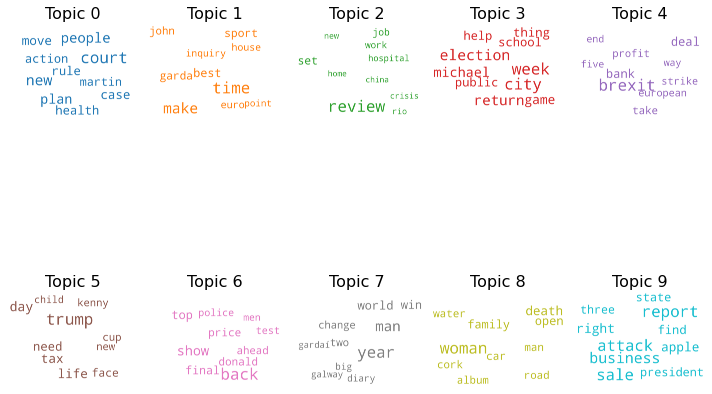

In [93]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = ireland_lda.show_topics(formatted=False)

fig, axes = plt.subplots(2, 5, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

---

---